# Testing Mouth Open/Close Detection

In [2]:
from commonfunctions import *
import math
from skimage import filters
from skimage import data
from skimage.color import rgb2gray

import skfuzzy as fuzz
import dlib

%matplotlib inline
%load_ext autoreload
%autoreload 2

(768, 512, 3)


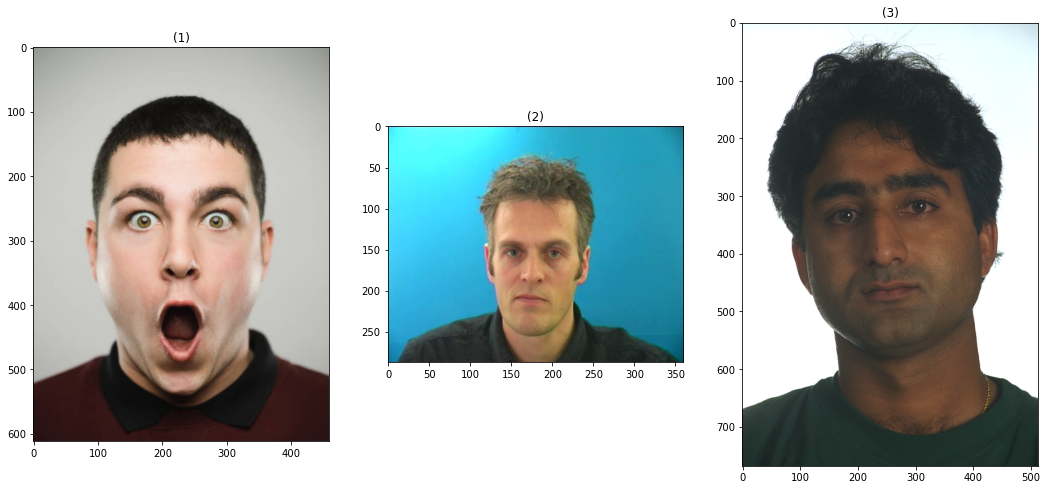

In [78]:
img_PPM=io.imread("00616_940928_fb.ppm")
print(img_PPM.shape)
img_open = io.imread('test.jpg')
# img_open=img_open[:,:,:3]
img_close = io.imread('frame69.jpg')
show_images([img_open, img_close,img_PPM])

In [79]:
def detectMouth(img):
    # detect face:
    detector = dlib.get_frontal_face_detector()
    dets = detector(img, 1)
    print("Number of faces detected: {}".format(len(dets)))

    for k, d in enumerate(dets):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))

    face = img[d.top():d.bottom(), d.left():d.right()]
    dimensions_face=face.shape
    mouth = face[int(dimensions_face[0]/2+(0.05*(d.bottom()-d.top()))):,:,:]


    quarter_face=mouth.shape[1]//4
    mouth= mouth[:,quarter_face:quarter_face*3,:]

    dimensions_mouth=mouth.shape

    io.imshow(face)
    io.imshow(mouth)
    io.show()
    return mouth , dimensions_mouth

In [80]:
def PixelsCount(image):
    return image.shape[0]*image.shape[1]

In [81]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [82]:
def selectLipRegion(mouth, dimensions_mouth):
    R = mouth[:,:,0]
    G = mouth[:,:,1]

    print(mouth.shape)
    # calculate chromatism
    chromatism = 2 * np.arctan((R-G)/R) / np.pi

    io.imshow(chromatism)
    io.show()
    chromatism = chromatism.reshape(-1,1)

    sorted_chromatism = -np.sort(-chromatism,axis=None,)

    chromatism_mouth_perc = int(chromatism.shape[0] * 0.15)
    print("15 percent :",chromatism_mouth_perc)
    chromatsim_largest_twenty=sorted_chromatism[0:chromatism_mouth_perc]


    chromatism = chromatism.reshape(dimensions_mouth[0],dimensions_mouth[1])
    io.imshow(chromatism)
    io.show()

    #print(chromatism in chromatsim_largest_twenty)
    new_img = np.zeros(dimensions_mouth)

    for i in range(0,dimensions_mouth[0]):
        for j in range(0,dimensions_mouth[1]):
            if chromatism[i,j] in chromatsim_largest_twenty:
                new_img[i,j]=255
            else:
                new_img[i,j]=0

    #new_img = chromatism[x for x in chromatsim_largest_twenty]
    io.imshow(new_img)
    io.show()

    return new_img


In [83]:
def contourIntersect(contour1, contour2):
    intersection = cv2.pointPolygonTest(contour1,(int(contour2[0][0][0]),int(contour2[0][0][1])),False)
    return intersection

In [84]:
def getROI(mouth):

    #showing contours
    temp = np.zeros_like(mouth)
    #one connected component or 2 connected component
    connected = True  

    # get 2 largest contours 
    largest_two_cnts=contours[0:2]  
    print(cv2.contourArea(largest_two_cnts[0]))
    cv2.drawContours(temp, largest_two_cnts, -1, (255,0,0), 1) #draw all contours
    show_images([temp],["2 largest cnts"])


    #if 2 components are nested , inside = 1 , else , components are not connected
    inside = contourIntersect(largest_two_cnts[0],largest_two_cnts[1])   

    if inside>0:
        connected=True
    else:
        connected=False

    if connected: # if connected , draw bounding rect for largest (outer contour)
        x,y,w,h = cv2.boundingRect(largest_two_cnts[0])
        cv2.rectangle(temp,(x,y),(x+w,y+h),(255,255,255),1)
        print("connected ",x,y,w,h)
        ROI = mouth_open[max(2,y-int(0.10*mouth.shape[0])):min(int(y+h+int(0.10*mouth.shape[0])),mouth.shape[0]),max(2,x-int(0.2*mouth.shape[1])):min(mouth.shape[1],x+w+int(0.2*mouth.shape[1])),:]
    else:   #else , draw bounding rect for both region
        x1,y1,w1,h1 = cv2.boundingRect(largest_two_cnts[0])     
        cv2.rectangle(temp,(x1,y1),(x1+w1,y1+h1),(255,255,255),1)

        x2,y2,w2,h2 = cv2.boundingRect(largest_two_cnts[1])
        cv2.rectangle(temp,(x2,y2),(x2+w2,y2+h2),(255,255,255),1)

        print("area difference : ",cv2.contourArea(largest_two_cnts[0])-cv2.contourArea(largest_two_cnts[1]))           
        if cv2.contourArea(largest_two_cnts[0])-cv2.contourArea(largest_two_cnts[1]) >500:      #if the size of second largest is negligible in comparison to first , discard it
            print("not connected ",x1,y1,w1,h1)
            ROI = mouth_open[max(2,y1-int(0.10*mouth.shape[0])):min(mouth.shape[0],y1+h1+int(0.10*mouth.shape[0])),max(2,x1-int(0.2*mouth.shape[1])):min(mouth.shape[1],x1+w1+int(0.2*mouth.shape[1])),:]
        else:
            minx=min([x1,x2])               #get the minx maxx miny maxy of the 2 bounding rectangles combined
            maxx=max([x1+w1,x2+w2])
            miny=min([y1,y2])
            maxy=max([y1+h1,y2+h2])
            print("not connected ",miny,maxy,minx,maxx)
            ROI = mouth_open[max(2,miny-int(0.10*mouth.shape[0])):min(mouth.shape[0],maxy+int(0.10*mouth.shape[0])),max(2,minx-int(0.2*mouth.shape[1])):min(mouth.shape[1],maxx+int(0.2*mouth.shape[1])),:]         #retrieve ROI

    return ROI

Number of faces detected: 1
Detection 0: Left: 63 Top: 170 Right: 384 Bottom: 491


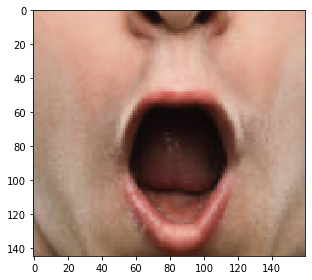

(145, 160, 3)


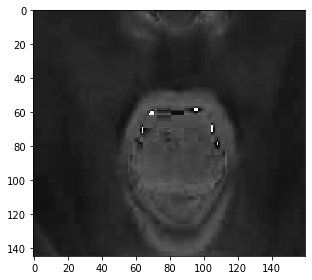

15 percent : 3480


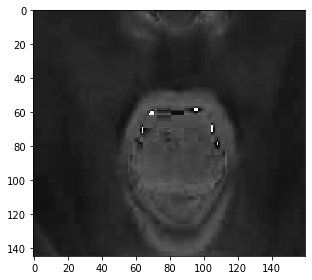

C:\Users\myass\anaconda3\envs\gp\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


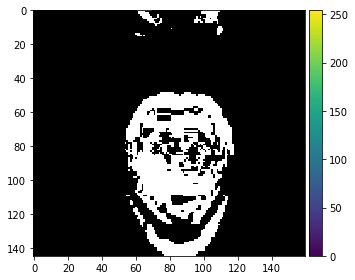

<class 'numpy.uint8'>


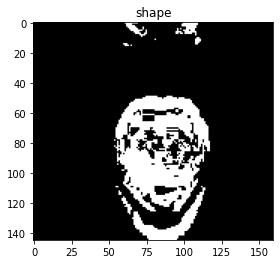

In [85]:
mouth_open , dim_open = detectMouth(img_open)
mouth = selectLipRegion(mouth_open, dim_open)
mouth = np.uint8( rgb2gray(mouth) *255 ) 

print(type(mouth[0][0]))

show_images([mouth],["shape"])



contours, hierarchy = cv2.findContours(mouth, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)



In [86]:
contours=sorted(contours,key=lambda x: cv2.contourArea(x),reverse=True) #sorted contours descendingly according to area

3482.0


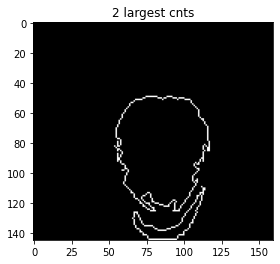

area difference :  3113.0
not connected  54 49 64 77


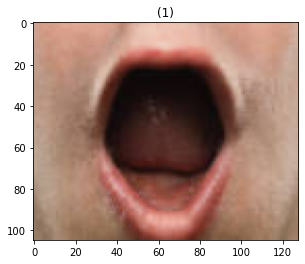

In [87]:
# cv2.drawContours(temp, contours, 0, (255,0,0), 1) #draw all contours
# show_images([temp])

ROI = getROI(mouth)

show_images([ROI])


### Challenges:
1. how to detect whether lips is connected or not -> when to select one biggest contour / 2 biggest contours?

# Find mouth contours


**approach 1 - RGB based**

(33, 74, 3)
number pixels : 2442
skin value : 1562
n : 162
iteration : 1
Threshold [35]


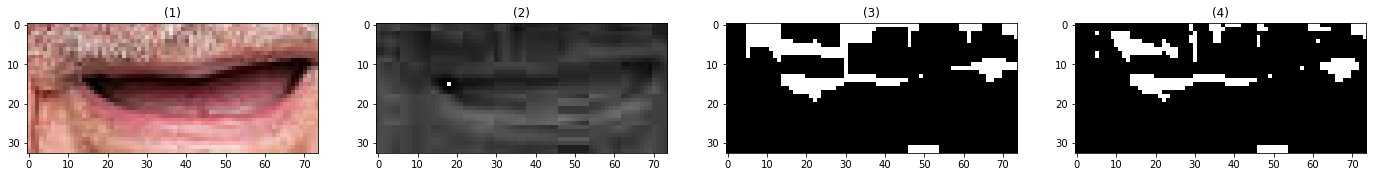

In [12]:
#calculate threshold T for segmentation

print(ROI.shape)

#calculate R - G 
red_minus_green = ROI[:,:,0]-ROI[:,:,1]

skin_value=0
n=0
new_img=np.zeros((ROI.shape[0],ROI.shape[1]))
k=0 #debug

while skin_value <= int((1/20)*PixelsCount(new_img)):
    #reshape R - G  to a vector
    red_minus_green_vector = red_minus_green.reshape(-1,1)

    top_10 = int(0.1*red_minus_green_vector.shape[0])  # top 10% pixels number in R-G values


    red_minus_green_sorted = sorted(red_minus_green_vector)  # ascendigly sort R_G values
    red_minus_green_top_10_plus_n = red_minus_green_sorted[0:top_10+n]   # pick smallest 10% values + n

    red_minus_green = red_minus_green.reshape(ROI.shape[0],ROI.shape[1])    #rstore the vector into an image again 

    new_img = red_minus_green == red_minus_green_top_10_plus_n[0]  # set pixels having value equal to top value to 1  

    for i in range(1,top_10+n):       #repeat for the top 10% values in R-G
        new_img |= red_minus_green == red_minus_green_top_10_plus_n[i] 

    new_img = np.uint8(new_img*255)  #convert float to uint
    new_img = closing(new_img,selem=square(5))  #perform a closing operation to remove gaps

    contours, hierarchy = cv2.findContours(new_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours=sorted(contours,key=lambda x: cv2.contourArea(x),reverse=True) #sorted contours descendingly according to area

    largest_two_cnts=contours[0:2]
    x1,y1,w1,h1 = cv2.boundingRect(largest_two_cnts[0])     

    #cv2.rectangle(new_img,(x1,y1),(x1+w1,y1+h1),(255,255,255),1)

    minx=min([x1])               #get the minx maxx miny maxy of the 2 bounding rectangles combined
    maxx=max([x1+w1])
    miny=min([y1])
    maxy=max([y1+h1])

    mouth_region = new_img[miny:maxy,minx:maxx]

    skin_value = PixelsCount(new_img)-PixelsCount(mouth_region)

    n += int( (1/15)*PixelsCount(new_img) )
    k+=1

    print("number pixels :",PixelsCount(new_img))
    print("skin value :" ,skin_value)
    print("n :" , n)
    print("iteration :" , k)

T = red_minus_green_top_10_plus_n[-1]

print("Threshold",T) 

final_image = np.zeros((red_minus_green.shape[0],red_minus_green.shape[1]))

for i in range(red_minus_green.shape[0]):
    for j in range(red_minus_green.shape[1]):

        if (1)*ROI[:,:,0][i,j] - ROI[:,:,1][i,j] <= T:
            final_image[i,j] = 1 
        elif((0)*ROI[:,:,0][i,j] - ROI[:,:,1][i,j] > T):
            final_image[i,j] = 0 

# final_image[red_minus_green <= T] = (255)*ROI[:,:,0] * ROI[:,:,1] 
# final_image[red_minus_green > T] = (0)*ROI[:,:,0] * ROI[:,:,1]

show_images([ROI,red_minus_green,new_img,final_image])


**approach 2 - fuzzy C-means based**

[[ 34.37359812  35.07170887  35.75100057  32.44791091  31.48706269
   35.11707012  40.55325061  46.01124239  46.1396765   44.98105176
   50.01015608  50.76649425  47.78306519  40.5663725   34.18413826
   44.25174936  52.68701937  65.16513392  71.98572623  74.62778643
   74.29866305  77.9303028   90.34457022 102.79918808 102.29639664
   90.91501107  75.40825094  71.45222938  70.55978408  70.19846452
   59.74759966  43.5694729   38.6611109 ]
 [ 44.38611288  45.53097154  33.52605358  34.19451138  35.4428559
   36.86993415  38.75323241  40.07645434  40.68055663  41.25710106
   37.09748161  38.28343684  38.87711564  37.31137477  37.28295716
   48.86910503  50.66693204  58.49503029  63.01025549  65.04330123
   65.28620026  62.19129314  60.25726421  60.78730289  60.77778022
   59.14844507  52.88802999  51.31275916  50.91534444  51.15499663
   49.29953392  46.28717769  46.09981027]]


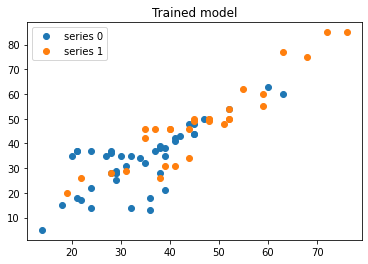

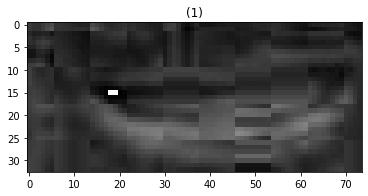

In [19]:
f = (ROI[:,:,0]-ROI[:,:,1]) + (ROI[:,:,2]-ROI[:,:,1])

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        f, 2, 2, error=0.005, maxiter=1000, init=None)

cluster_membership = np.argmax(u, axis=0)
print(cntr)
print(u)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(2):
    ax2.plot(f[0, u.argmax(axis=0) == j],
             f[1, u.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax2.legend()

show_images([f])

**approach 3 - YCbCr color space based**

In [88]:
ROI_Ycbcr = rgb2ycbcr(ROI)

Y = ROI_Ycbcr[:,:,0]
cb = ROI_Ycbcr[:,:,1]
cr = ROI_Ycbcr[:,:,2]

#N = np.sum(cb > 100)
N1=0
s1=0
nk=dict()
for i in range(cb.shape[0]):
    for j in range(cb.shape[1]):
        for k in range(100,256):
            if cb[i,j] == k and (k not in nk):
                nk[k] = 1
            elif  cb[i,j] == k:
                nk[k]+=1
             



In [89]:
#lip color and color of skin of Cb component are more than 100
# ni : number of pixels who’s value is i
#N : the number of pixels who’s grey value is greater than a certain gray level

N1 = sum(nk.values())

S1 = sum([key * value for key,value in nk.items()])

t1 = S1 / N1


In [90]:
N2=0
s2=0
nk=dict()
for i in range(cr.shape[0]):
    for j in range(cr.shape[1]):
        for k in range(150,256):
            if cr[i,j] == k and (k not in nk):
                nk[k] = 1
            elif  cr[i,j] == k:
                nk[k]+=1

In [91]:
N2 = sum(nk.values())

S2 = sum([key * value for key,value in nk.items()])

t2 = S2 / N2

In [92]:
thresh1 = int((t1 + t2)/2)
thresh2 = int(t2)

In [93]:
cbcr_avg = np.uint8((np.int16(cb)+np.int16(cr))/2)
cbcr_avg_binary = cbcr_avg > thresh1
cr_binary = cr > thresh2

lip_noisy = np.logical_and(cbcr_avg_binary,cr_binary)
lip_cleaned = closing(lip_noisy,selem=square(5))
lip_cleaned = opening(lip_cleaned,selem=square(3))

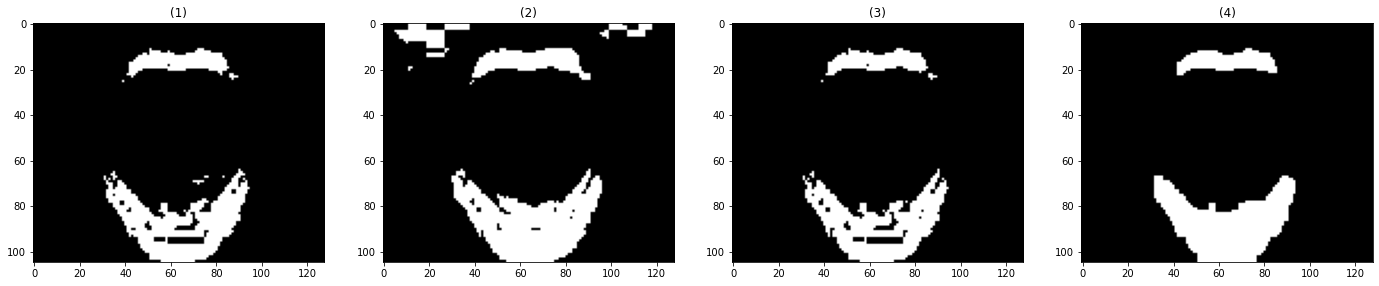

In [94]:
show_images([cbcr_avg_binary,cr_binary,lip_noisy,lip_cleaned])